# Util functions

In [1]:
import os

def get_method_name(log_path: str) -> str:
    file_name = os.path.splitext(os.path.basename(log_path))[0]
    file_name_split = file_name.split('_')
    
    if file_name_split[4] == 'EDF':
        method_name = 'EDF'
    else:
        method_name = file_name_split[1]

    return method_name

In [2]:
from typing import Dict

def get_classification(log: Dict) -> str:
    if 'deadline_miss' in log.keys() and 'early_detection' in log.keys():
        classification = 'TP'
    elif 'deadline_miss' not in log.keys() and 'early_detection' in log.keys():
        classification = 'FP'
    elif 'deadline_miss' in log.keys() and 'early_detection' not in log.keys():
        classification = 'FN'
    elif 'deadline_miss' not in log.keys() and 'early_detection' not in log.keys():
        classification = 'TN'

    return classification

## Plot

In [3]:
import japanize_matplotlib

In [4]:
from typing import Generator
import pandas as pd
import numpy as np

def color_pattern_gen(
    df: pd.DataFrame,
    use_pattern: bool = True
) -> Generator:
    patterns = ["//" , "\\" , "++" , "..", "o", "x", "|" , "-", "O", "*" ]
    colors = [str(round(c, 1)) for c in np.arange(0.2, 1.0, 0.8/len(df))]
    
    for i in range(len(df)):
        args = {'color': colors[i],
               'edgecolor': 'black',
               'linewidth': 1}
        if use_pattern:
            args['hatch'] = patterns[i % len(df)]

        yield args

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def stack_bar_plot(
    df: pd.DataFrame,
    xlabel: str = '',
    save_name: str = ''
) -> None:
    cp_gen = color_pattern_gen(df)
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in range(len(df)):
        ax.bar(df.columns,
                df.iloc[i], 
                bottom=df.iloc[:i].sum(),
                width=0.4,
                **next(cp_gen)
                )
    ax.set_xlabel(xlabel=xlabel, fontsize=20)
    ax.tick_params(labelsize=16)
    ax.legend(df.index, fontsize=16, loc='lower right')
    
    if save_name:
        plt.savefig(f'./results/figures/{save_name}')
    
    plt.show()

In [6]:
import numpy as np
from matplotlib.colors import ListedColormap

def line_plot(
    df: pd.DataFrame,
    xlabel: str = '',
    ylabel: str = '',
    save_name: str = ''
) -> None:
    colors = [str(round(c, 1)) for c in np.arange(0, 0.6, 0.6/len(df))]
    cmap = ListedColormap(colors, name="custom")
    fig, ax = plt.subplots()
    df.plot(ax=ax,
            figsize=(8, 6),
            colormap=cmap,
            style=['s--', 'o:', '^-.', 'D-'],
            linewidth=2,
            markersize=6,
            markeredgewidth=2,
            grid=True,
            fontsize=16)
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks(np.arange(0, 1.01, 0.1))
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.legend(fontsize=13, loc='lower right')
    
    if save_name:
        plt.savefig(f'./results/figures/{save_name}')
    
    plt.show()

In [7]:
def rename_colmuns_to_with_proposed(
    df: pd.DataFrame
) -> None:
    df.rename(columns={'proposed': 'Proposed LLF',
                       'Igarashi': 'Igarashi [1] (with proposed threshold)',
                       'Saidi': 'Saidi [2] (with proposed threshold)',
                       'EDF': 'EDF [3] (with proposed threshold)'},
              inplace=True)

# Utilization varied

In [8]:
def get_utilization(log_path: str) -> float:
    file_name = os.path.splitext(os.path.basename(log_path))[0]
    utilization_str = file_name.split('_')[-1]
    utilization = float(utilization_str.split('=')[1])

    if 0.50 <= utilization < 0.55:
        utilization = 50
    elif 0.55 <= utilization < 0.60:
        utilization = 55
    elif 0.60 <= utilization < 0.65:
        utilization = 60
    elif 0.65 <= utilization < 0.7:
        utilization = 65
    elif 0.7 <= utilization < 0.75:
        utilization = 70
    elif 0.75 <= utilization < 0.8:
        utilization = 75
    elif 0.8 <= utilization < 0.85:
        utilization = 80
    elif 0.85 <= utilization < 0.9:
        utilization = 85
    elif 0.9 <= utilization < 1.0:
        utilization = 90

    return utilization


In [9]:
import glob
import pandas as pd
import yaml
import numpy as np

METHOD_NAMES = ['proposed', 'Igarashi', 'Saidi', 'EDF']
UTILIZATION_VALUES = [str(round(c, 0)) for c in np.arange(60, 95, 5)]

utilization_df_dict = {}
for method in METHOD_NAMES:
    utilization_df_dict[method] = pd.DataFrame(index=['TP', 'FN', 'TN', 'FP'],
                                               columns=UTILIZATION_VALUES)
    utilization_df_dict[method].fillna(0, inplace=True)

In [10]:
log_paths = glob.glob("./results/utilization_varied/*.yaml")

for log_path in log_paths:
    with open(log_path, "r") as f:
        log = yaml.safe_load(f)
    
    method_name = get_method_name(log_path)
    utilization = get_utilization(log_path)
    classification = get_classification(log)
    utilization_df_dict[method_name].at[str(classification), str(utilization)] += 1

## Precision

In [11]:
precision_df = pd.DataFrame(index=METHOD_NAMES,
                            columns=UTILIZATION_VALUES)

for method in METHOD_NAMES:
    precision_df.loc[method] = utilization_df_dict[method].loc['TP'] / (utilization_df_dict[method].loc['TP'] + utilization_df_dict[method].loc['FP'])

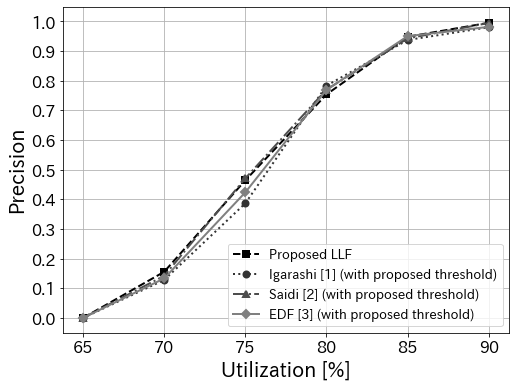

In [12]:
precision_df = precision_df.T
rename_colmuns_to_with_proposed(precision_df)
line_plot(precision_df, 'Utilization [%]', 'Precision', 'line_plot_precision.pdf')

In [13]:
precision_df.mean()

Proposed LLF                              0.552964
Igarashi [1] (with proposed threshold)    0.536037
Saidi [2] (with proposed threshold)       0.553493
EDF [3] (with proposed threshold)         0.543051
dtype: float64

## Recall

In [14]:
recall_df = pd.DataFrame(index=METHOD_NAMES,
                            columns=UTILIZATION_VALUES)

for method in METHOD_NAMES:
    recall_df.loc[method] = utilization_df_dict[method].loc['TP'] / (utilization_df_dict[method].loc['TP'] + utilization_df_dict[method].loc['FN'])

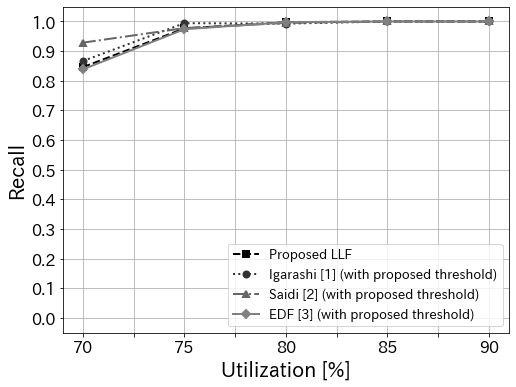

In [15]:
recall_df.drop('65', axis=1, inplace=True)  # HACK
recall_df = recall_df.T
rename_colmuns_to_with_proposed(recall_df)
line_plot(recall_df, 'Utilization [%]', 'Recall', 'line_plot_recall.pdf')

## Specificity

In [16]:
specificity_df = pd.DataFrame(index=METHOD_NAMES,
                         columns=UTILIZATION_VALUES)

for method in METHOD_NAMES:
    specificity_df.loc[method] = utilization_df_dict[method].loc['TN'] / (utilization_df_dict[method].loc['TN'] + utilization_df_dict[method].loc['FP'])

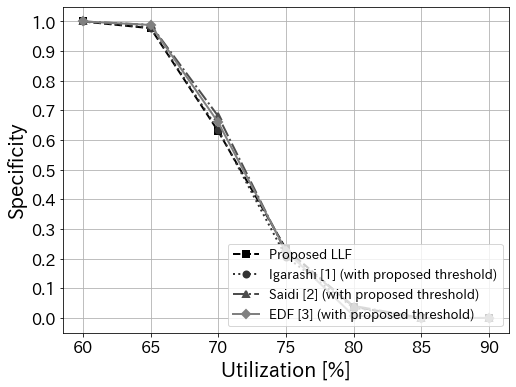

In [17]:
specificity_df = specificity_df.T
rename_colmuns_to_with_proposed(specificity_df)
line_plot(specificity_df, 'Utilization [%]', 'Specificity', 'line_plot_specificity.pdf')

## Accuracy

In [18]:
accuracy_df = pd.DataFrame(index=METHOD_NAMES,
                              columns=UTILIZATION_VALUES)

for method in METHOD_NAMES:
    accuracy_df.loc[method] = ((utilization_df_dict[method].loc['TP'] + utilization_df_dict[method].loc['TN'])
                                  / (utilization_df_dict[method].loc['TP'] + utilization_df_dict[method].loc['TN'] + utilization_df_dict[method].loc['FP'] + utilization_df_dict[method].loc['FN']))

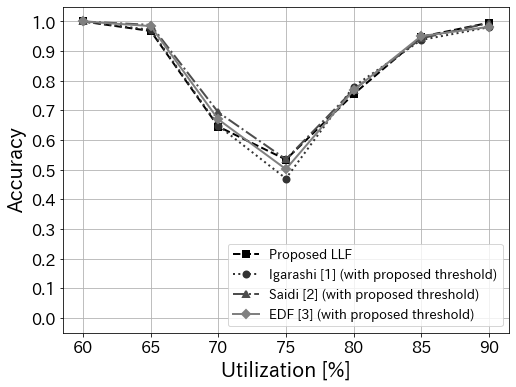

In [19]:
accuracy_df = accuracy_df.T
rename_colmuns_to_with_proposed(accuracy_df)
# accuracy_df.rename(columns={'Proposed LLF': '提案アルゴリズム',
#                    'Igarashi (with proposed threshold)': 'Igarashi, J. IPSJ (提案laxityを早期検知の閾値として使用)',
#                    'Saidi (with proposed threshold)': 'Saidi, TMS (提案laxityを早期検知の閾値として使用)',
#                    'EDF (with proposed threshold)': 'Earliest Deadline First (提案laxityを早期検知の閾値として使用)'},
#           inplace=True)
line_plot(accuracy_df, 'Utilization [%]', 'Accuracy', 'line_plot_accuracy.pdf')

# F-measure

In [20]:
F_df = pd.DataFrame(index=METHOD_NAMES,
                    columns=UTILIZATION_VALUES)

for method in METHOD_NAMES:
    recall = utilization_df_dict[method].loc['TP'] / (utilization_df_dict[method].loc['TP'] + utilization_df_dict[method].loc['FN'])
    precision = utilization_df_dict[method].loc['TP'] / (utilization_df_dict[method].loc['TP'] + utilization_df_dict[method].loc['FP'])
    F_df.loc[method] = ((2 * recall * precision)
                            / (recall + precision))

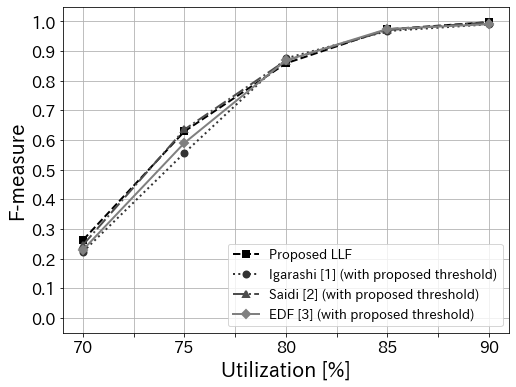

In [21]:
F_df = F_df.T
rename_colmuns_to_with_proposed(F_df)
line_plot(F_df, 'Utilization [%]', 'F-measure', 'line_plot_F_measure.pdf')

## Four ratio

In [22]:
for method in METHOD_NAMES:
    utilization_df_dict[method] = \
        utilization_df_dict[method].div(utilization_df_dict[method].sum(axis=0), axis=1)
    utilization_df_dict[method].rename(index={'TP': 'TP Ratio', 'FN': 'FN Ratio', 'TN': 'TN Ratio', 'FP': 'FP Ratio'}, inplace=True)

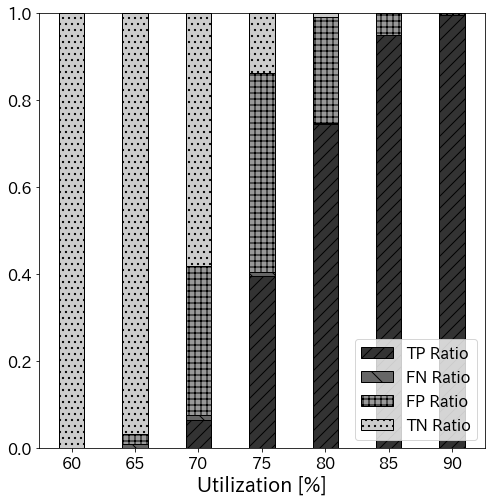

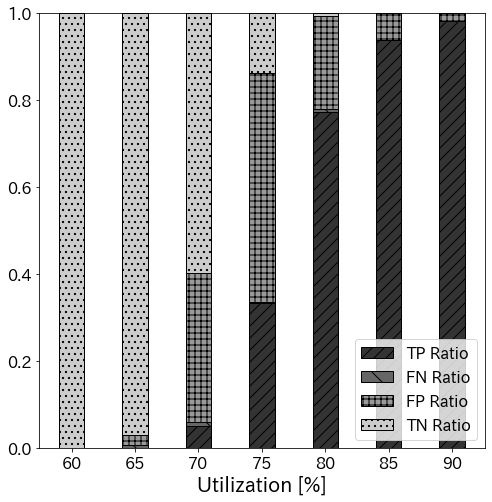

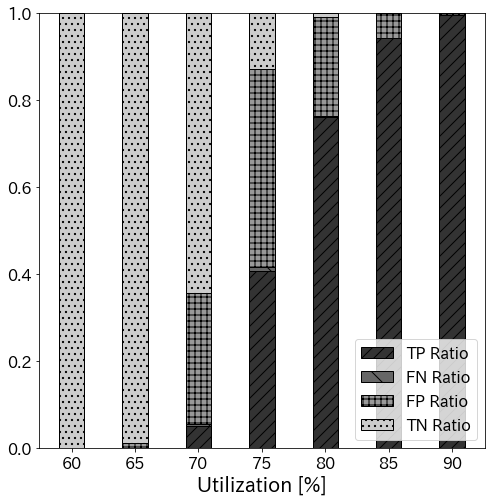

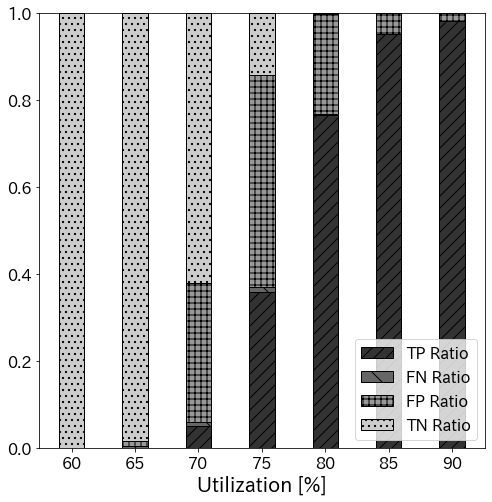

In [23]:
for method in METHOD_NAMES:
    stack_bar_plot(utilization_df_dict[method].reindex(index=['TP Ratio', 'FN Ratio', 'FP Ratio', 'TN Ratio']), 
                   xlabel='Utilization [%]',
                   save_name=f'stack_bar_four_ratio_{method}.pdf')

# Earlier time

In [24]:
earlier_time_dict = {'proposed': [],
                     'Igarashi': [],
                     'Saidi': [],
                     'EDF': []}

log_paths = glob.glob("./results/utilization_varied/*.yaml") + glob.glob("./results/alpha_varied/*.yaml")
for log_path in log_paths:
    with open(log_path, "r") as f:
        log = yaml.safe_load(f)

    if get_classification(log) == 'TP':
        earlier_time = (log['deadline_miss']['deadline_miss_time']
                        - log['early_detection']['detection_time'])
        earlier_time_dict[get_method_name(log_path)].append(earlier_time)

In [25]:
METHOD_NAMES = ['proposed', 'Igarashi', 'Saidi', 'EDF']

for method in METHOD_NAMES:
    print(f'{method} ave: {sum(earlier_time_dict[method])/len(earlier_time_dict[method])}')
    print(f'{method} max: {max(earlier_time_dict[method])}')

proposed ave: 644502.011594203
proposed max: 1164000
Igarashi ave: 638781.9724950884
Igarashi max: 1164000
Saidi ave: 644175.9903846154
Saidi max: 1164000
EDF ave: 637341.7919103313
EDF max: 1164000


# Deadline miss ratio of random DAGs

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_bar_plot(
    df: pd.DataFrame,
    ylabel: str = '',
    xlabel: str = '',
    save_name: str = ''
) -> None:
    cp_gen = color_pattern_gen(df, False)
    data = df.stack().rename_axis(['method_name', xlabel]).reset_index().rename(columns={0: ylabel})
    fig, _ = plt.subplots(figsize=(8, 6))
    ax = sns.barplot(data=data,
                x=xlabel,
                y=ylabel,
                hue='method_name',
                **next(cp_gen))

    ax.set_xlabel(xlabel=xlabel, fontsize=20)
    ax.set_ylabel(ylabel=ylabel, fontsize=20)
    ax.tick_params(labelsize=16)
    ax.legend(fontsize=16, loc='upper right')
    
    if save_name:
        plt.savefig(f'./results/figures/{save_name}')
    
    plt.show()

## Alpha varied

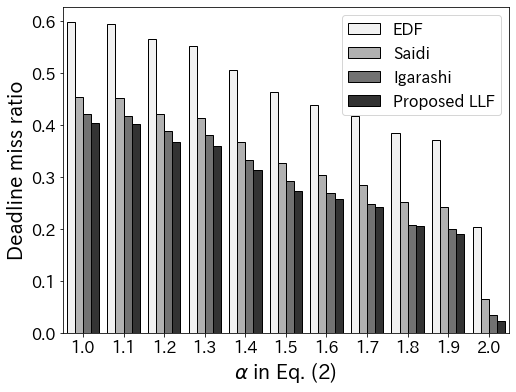

In [27]:
deadline_miss_df = pd.DataFrame(
    data={'1.0': pd.Series([0.404, 0.421, 0.454, 0.598], index=['Proposed LLF', 'Igarashi', 'Saidi', 'EDF']),
          '1.1': pd.Series([0.402, 0.418, 0.452, 0.594], index=['Proposed LLF', 'Igarashi', 'Saidi', 'EDF']),
          '1.2': pd.Series([0.367, 0.389, 0.421, 0.566], index=['Proposed LLF', 'Igarashi', 'Saidi', 'EDF']),
          '1.3': pd.Series([0.359, 0.38, 0.413, 0.553], index=['Proposed LLF', 'Igarashi', 'Saidi', 'EDF']),
          '1.4': pd.Series([0.314, 0.332, 0.368, 0.506], index=['Proposed LLF', 'Igarashi', 'Saidi', 'EDF']),
          '1.5': pd.Series([0.273, 0.292, 0.326, 0.463], index=['Proposed LLF', 'Igarashi', 'Saidi', 'EDF']),
          '1.6': pd.Series([0.257, 0.269, 0.303, 0.439], index=['Proposed LLF', 'Igarashi', 'Saidi', 'EDF']),
          '1.7': pd.Series([0.242, 0.247, 0.284, 0.418], index=['Proposed LLF', 'Igarashi', 'Saidi', 'EDF']),
          '1.8': pd.Series([0.205, 0.208, 0.251, 0.384], index=['Proposed LLF', 'Igarashi', 'Saidi', 'EDF']),
          '1.9': pd.Series([0.191, 0.199, 0.243, 0.372], index=['Proposed LLF', 'Igarashi', 'Saidi', 'EDF']),
          '2.0': pd.Series([0.022, 0.034, 0.066, 0.204], index=['Proposed LLF', 'Igarashi', 'Saidi', 'EDF'])}
)

compare_bar_plot(deadline_miss_df.reindex(index=['EDF', 'Saidi', 'Igarashi', 'Proposed LLF']),
                 'Deadline miss ratio',
                 r'$\alpha$ in Eq. (2)',
                 'DMR_alpha_varied.pdf')

## Number of cores varied

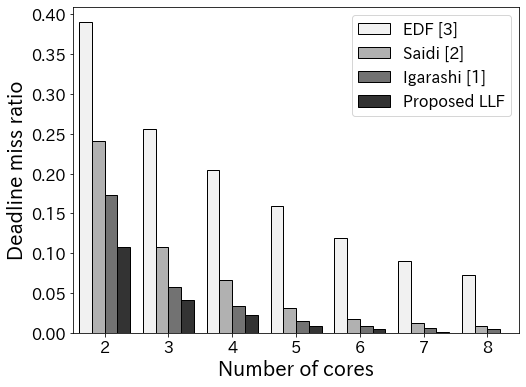

In [28]:
deadline_miss_df = pd.DataFrame(
    data={'2': pd.Series([0.108, 0.173, 0.241, 0.39], index=['Proposed LLF', 'Igarashi [1]', 'Saidi [2]', 'EDF [3]']),
          '3': pd.Series([0.041, 0.057, 0.108, 0.256], index=['Proposed LLF', 'Igarashi [1]', 'Saidi [2]', 'EDF [3]']),
          '4': pd.Series([0.022, 0.034, 0.066, 0.204], index=['Proposed LLF', 'Igarashi [1]', 'Saidi [2]', 'EDF [3]']),
          '5': pd.Series([0.008, 0.015, 0.031, 0.159], index=['Proposed LLF', 'Igarashi [1]', 'Saidi [2]', 'EDF [3]']),
          '6': pd.Series([0.005, 0.009, 0.017, 0.119], index=['Proposed LLF', 'Igarashi [1]', 'Saidi [2]', 'EDF [3]']),
          '7': pd.Series([0.001, 0.006, 0.012, 0.09], index=['Proposed LLF', 'Igarashi [1]', 'Saidi [2]', 'EDF [3]']),
          '8': pd.Series([0, 0.005, 0.008, 0.072], index=['Proposed LLF', 'Igarashi [1]', 'Saidi [2]', 'EDF [3]'])}
)

compare_bar_plot(deadline_miss_df.reindex(index=['EDF [3]', 'Saidi [2]', 'Igarashi [1]', 'Proposed LLF']),
                 'Deadline miss ratio',
                 'Number of cores',
                 'DMR_numcore_varied.pdf')

# Alpha varied

In [29]:
def get_alpha(log_path: str) -> float:
    file_name = os.path.splitext(os.path.basename(log_path))[0]
    alpha_str = file_name.split('_')[2]
    alpha = float(alpha_str.split('=')[1])

    return round(alpha, 1)

In [30]:
import glob
import pandas as pd
import yaml
import numpy as np

METHOD_NAMES = ['proposed', 'Igarashi', 'Saidi', 'EDF']

alpha_df_dict = {}
for method in METHOD_NAMES:
    alpha_df_dict[method] = pd.DataFrame(index=['TP Ratio', 'FN Ratio', 'TN Ratio', 'FP Ratio'],
                                         columns=[str(round(c, 1)) for c in np.arange(1.5, 2.4, 0.1)])
    alpha_df_dict[method].fillna(0, inplace=True)

In [31]:
log_paths = glob.glob("./results/alpha_varied/*.yaml")

for log_path in log_paths:
    with open(log_path, "r") as f:
        log = yaml.safe_load(f)
    
    method_name = get_method_name(log_path)
    alpha = get_alpha(log_path)
    classification = get_classification(log)
    alpha_df_dict[method_name].at[f'{classification} Ratio', str(round(alpha, 1))] += 1

KeyError: '2.4'

In [ ]:
alpha_df_dict['proposed']

,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3
TP Ratio,0,0,0,0,0,0,0,0,0
FN Ratio,0,0,0,0,0,0,0,0,0
TN Ratio,0,0,0,0,0,0,0,0,0
FP Ratio,0,0,0,0,0,0,0,0,0


In [ ]:
alpha_df_dict['Igarashi']

,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3
TP Ratio,44,97,98,90,80,69,65,61,61
FN Ratio,7,3,2,3,1,1,1,0,0
TN Ratio,0,0,0,0,2,5,3,3,2
FP Ratio,0,0,0,7,17,25,31,36,37


In [ ]:
alpha_df_dict['Saidi']

,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3
TP Ratio,0,0,0,0,0,0,0,0,0
FN Ratio,0,0,0,0,0,0,0,0,0
TN Ratio,0,0,0,0,0,0,0,0,0
FP Ratio,0,0,0,0,0,0,0,0,0


In [ ]:
alpha_df_dict['EDF']

,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3
TP Ratio,49,91,94,87,81,72,78,52,57
FN Ratio,2,9,5,5,2,1,2,0,0
TN Ratio,0,0,0,0,0,2,2,4,8
FP Ratio,0,0,1,8,17,25,18,44,35


In [ ]:
for method in METHOD_NAMES:
    alpha_df_dict[method] = \
        alpha_df_dict[method].div(alpha_df_dict[method].sum(axis=0), axis=1)

In [ ]:
alpha_df_dict['proposed']

,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3
TP Ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FN Ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TN Ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FP Ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
alpha_df_dict['Igarashi']

,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3
TP Ratio,0.862745,0.97,0.98,0.90,0.80,0.69,0.65,0.61,0.61
FN Ratio,0.137255,0.03,0.02,0.03,0.01,0.01,0.01,0.00,0.00
TN Ratio,0.000000,0.00,0.00,0.00,0.02,0.05,0.03,0.03,0.02
FP Ratio,0.000000,0.00,0.00,0.07,0.17,0.25,0.31,0.36,0.37


In [ ]:
alpha_df_dict['Saidi']

,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3
TP Ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FN Ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TN Ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FP Ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
alpha_df_dict['EDF']

,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3
TP Ratio,0.960784,0.91,0.94,0.87,0.81,0.72,0.78,0.52,0.57
FN Ratio,0.039216,0.09,0.05,0.05,0.02,0.01,0.02,0.00,0.00
TN Ratio,0.000000,0.00,0.00,0.00,0.00,0.02,0.02,0.04,0.08
FP Ratio,0.000000,0.00,0.01,0.08,0.17,0.25,0.18,0.44,0.35
